<a href="https://www.kaggle.com/code/lostinworlds/cluster-analysis-of-goodreads-reading-list?scriptVersionId=98321424" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Understanding patters in the GoodReads Reading list using KMeans clustering.**

# Introduction
In a world where there are countless books and it is near impossible for any one individual to read all of them, reading lists are a common feature. Such lists can assist a reader in finding books that they may enjoy or in an academic context, the relevant knowledge is acquired. 

Some such lists can be viewed on sites such as Goodreads, "the world’s largest site for readers and book recommendations" ([Goodreads, 2022](https://www.goodreads.com/about/us)). These lists can be extensive and as such, it is intriguing to examine whether there are patterns in the list and if the list is particularly long how an individual should approach the list. 

# Overview
Some lists on Goodreads are self explanatory, classifying books by themes or genre. However, lists such as ["Books That Everyone Should Read At Least Once"](https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page=1), can be more broad and therefore more mysterious. The list has over 26,000 books with a simple description "Books that encourage thought". 

As these lists are online, the data will need to be scrapped. Using a modified version of the code from [mee-kell](https://github.com/mee-kell/web-scraper/blob/master/web-scraper.py), the relevant data was scraped (see [modified code](https://github.com/Lostinworlds/ClusteringReadingList/blob/main/goodreads_webscrap.ipynb)).

The secured data requires some data processing. It can then be evaluated to locate any patterns in the dat. As for how to approach the list, clustering may offer some insights.  

In [1]:
# library for data handling
import numpy as np 
import pandas as pd

# library for kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px

# library for clustering
from sklearn.cluster import KMeans



/kaggle/input/goodreads-reading-list/Books_That_Everyone_Should_Read_At_Least_Once1.csv


In [2]:
# import and view data
df = pd.read_csv("/kaggle/input/goodreads-reading-list/Books_That_Everyone_Should_Read_At_Least_Once1.csv", index_col = False)
df.head()

,title,author,avg_rating,total_ratings
0,To Kill a Mockingbird,Harper Lee,4.27,"5,260,972"
1,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.48,"8,496,025"
2,Pride and Prejudice,Jane Austen,4.28,"3,595,947"
3,The Diary of a Young Girl,Anne Frank,4.17,"3,236,081"
4,Animal Farm,George Orwell,3.97,"3,260,451"


In [3]:
# examin row data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          4900 non-null   object
 1   author         4900 non-null   object
 2   avg_rating     4900 non-null   object
 3   total_ratings  4900 non-null   object
dtypes: object(4)
memory usage: 153.2+ KB


# Data Processing/Cleaning

Assessing the data indicates that there are some issues with the data. Some of the numerical values include text which is causing various issues. Whilst these errors may be fixed manually, given that the data consists of approx. 4900 books, the dropping the rows may be the most efficient. The dataset is large enough that the drop should not undermine the dataset significantly. 

In [4]:
# check data in avg_Ratings
df["avg_rating"].unique()

array(['4.27', '4.48', '4.28', '4.17', '3.97', '4.19', '4.32', '3.93',
       '3.81', '4.51', '4.38', '4.14', '4.26', '3.69', '3.75', '4.62',
       '4.13', '4.37', '4.12', '3.88', '3.98', '4.30', '4.58', '4.06',
       '4.10', '4.35', '4.57', '4.42', '4.22', '4.03', '3.82', '3.90',
       '4.24', '4.46', '4.23', '3.79', '4.07', '4.11', '4.25', '4.40',
       '3.99', '4.31', '3.92', '3.86', '4.20', '3.84', '4.34', '4.09',
       '3.43', '3.63', '4.05', 'really', '4.29', '4.43', '4.02', '3.89',
       '4.08', '3.52', '4.01', '4.16', '4.33', '4.39', '4.18', '4.36',
       '4.45', '4.44', '4.15', '3.83', '3.96', '4.55', '3.95', '3.85',
       '3.87', '3.60', '4.49', '3.62', '4.60', '3.58', '3.78', '3.68',
       '3.77', '3.91', '4.52', '3.66', '4.64', '4.21', '4.95', '4.04',
       '3.71', '3.59', '3.80', '3.74', '3.72', '3.76', '3.64', '4.50',
       '3.57', '4.47', '4.41', '3.55', '3.54', '3.46', '3.67', '4.59',
       '3.94', '3.51', '4.73', '3.70', '4.54', '3.42', '3.50', '3.61',
    

In [5]:
# remove rows with errors
df.drop(df[df["avg_rating"]=="really"].index, axis =0, inplace = True)
df.drop(df[df["avg_rating"]=="it"].index, axis =0, inplace = True)
df.drop(df[df["avg_rating"]=="liked"].index, axis =0, inplace = True)


This enables the numerical variables to be updated. As the avg_ratings can contain decimal places, it can be converted to a float whilst total_ratings must be a integer as decimal places should not be possible. 

In [6]:
# reformat numerical values
df["avg_rating"] = df["avg_rating"].str.replace(",","").astype(float)
df["total_ratings"] = df["total_ratings"].str.replace(",","").astype(int)

As the lists are maintained by users, there may be other hidden errors. One such issue includes duplicates. It is unlikely that any contributor may recall over 5000 titles and ensure that the new book added to the list is not already included. Authors can publish more than one book and titles can overlap. However, the likelihood of an author publishing a book under the same title is relatively low. There may be variations in the edition but that may not be a significant issue. For any duplicates, as the avg_ratings and total_ratings can differ and different approaches can be taken in deciding which entry to retain. 

For the purpose of this project the first entry will be retained to favour the user who first added the book to the list. 

In [7]:
# check if titles are repeated
df["title"].value_counts()

The Hunger Games (The Hunger Games #1)                3
Females of Valor (The Viking's Kurdish Love #2)       2
A Monster Calls                                       2
The Girl with the Dragon Tattoo (Millennium #1)       2
For the Love of Armin                                 2
                                                     ..
Ghost Park (Devil Barnett Detective Series Book 9)    1
Cold Comfort Farm                                     1
Understanding Power: The Indispensable Chomsky        1
Frankie the Ferret                                    1
Heart of Darfur                                       1
Name: title, Length: 4774, dtype: int64

In [8]:
# remove duplicated titles
df.drop_duplicates(subset=("title","author"), keep='first', inplace = True)

The end result is a dataset as follows: 
The dataset is still large with over 4700 entries. 

In [9]:
# check revised data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4780 entries, 0 to 4899
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          4780 non-null   object 
 1   author         4780 non-null   object 
 2   avg_rating     4780 non-null   float64
 3   total_ratings  4780 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 186.7+ KB


In [10]:
# examine descriptive statistics of the data
df.describe()

,avg_rating,total_ratings
count,4780.000000,4.780000e+03
mean,4.053588,1.397584e+05
std,0.277368,3.767257e+05
min,0.000000,0.000000e+00
25%,3.880000,7.448250e+03
50%,4.070000,3.848750e+04
75%,4.240000,1.191792e+05
max,4.950000,8.496025e+06


# Patterns in the data 
As the data is limited, the patters which can be identified may be limited. That being said, it appears that the most popular authors are Stephen King, William Shakespeare and Terry Pratchett. There is also 18 books where the author is listed as unknown (Anonymous). This is relatively large given that Anonymous appear 5th in the list of popular authors. 

In [11]:
# create dataframe of authors and number of appearance in data
authors = df["author"].value_counts().rename_axis("name").reset_index(name = "count")

#print Anonymous author entries
print("There are",authors.loc[authors["name"]=="Anonymous", "count"].tolist()[0],"entries where the name of the author is unknown.")

There are 18 entries where the name of the author is unknown.


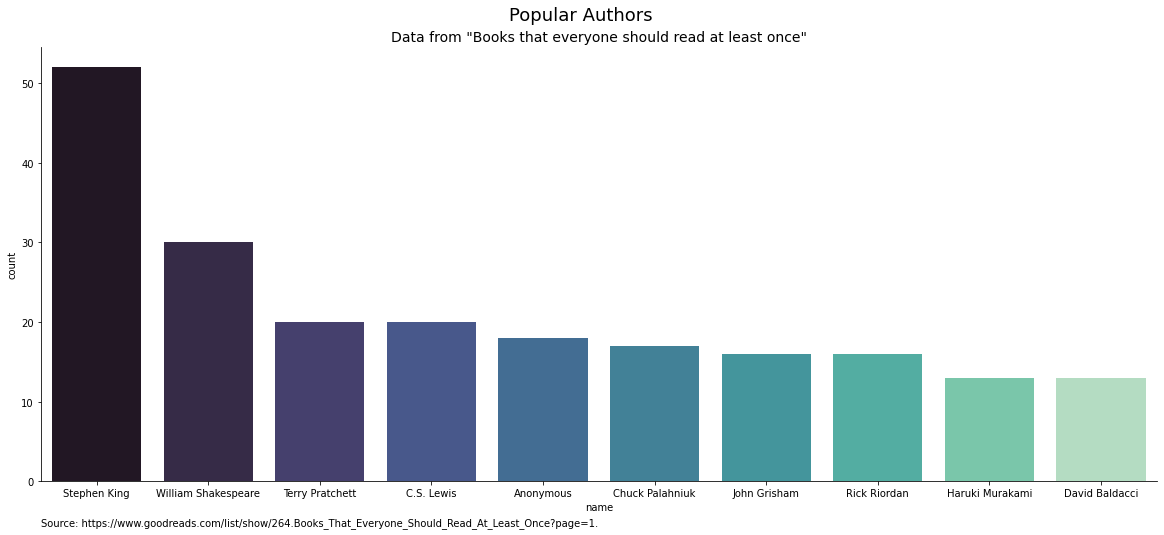

In [12]:
# create graph of authors and number of appearnces
plt.figure(figsize =(20,8))
sns.barplot(x = "name", y ="count", data = authors.head(10), palette = "mako")

# amend graph
plt.suptitle("Popular Authors", fontsize = 18, y =.95)
plt.title("Data from \"Books that everyone should read at least once\"", fontsize = 14)

plt.annotate('Source: https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page=1. ', (0,-.1), xycoords ='axes fraction' )

sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

Goodreads rating system enables the users to rate a book between 1-5. As such the distribution of the data is also between 1 and 5. Given the nature of the list, the majority of the data is grouped around 3-5. The inclusion of extremely low rating book is likely to be an outlier. 

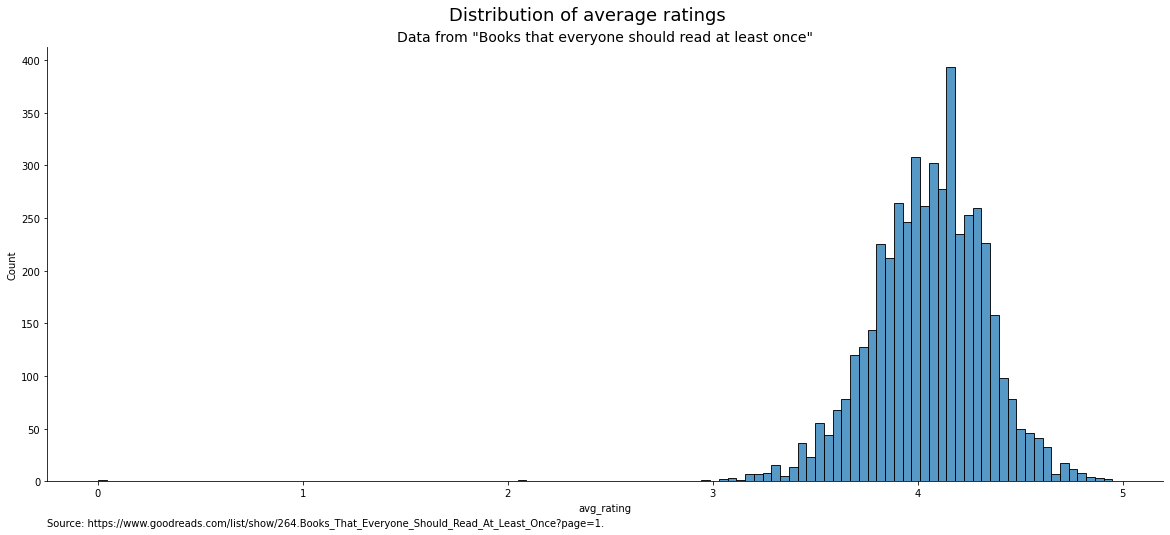

In [13]:
# create graph
plt.figure(figsize =(20,8))

sns.histplot(x = "avg_rating", data = df, palette = "mako")

# revise graph
plt.suptitle("Distribution of average ratings", fontsize = 18, y =.95)
plt.title("Data from \"Books that everyone should read at least once\"", fontsize = 14)

plt.annotate('Source: https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page=1. ', (0,-.1), xycoords ='axes fraction' )

sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

As for total ratings, due to the nature of the data it is skewed to the right. However, there are suspicious entries as at least one book has no ratings. 

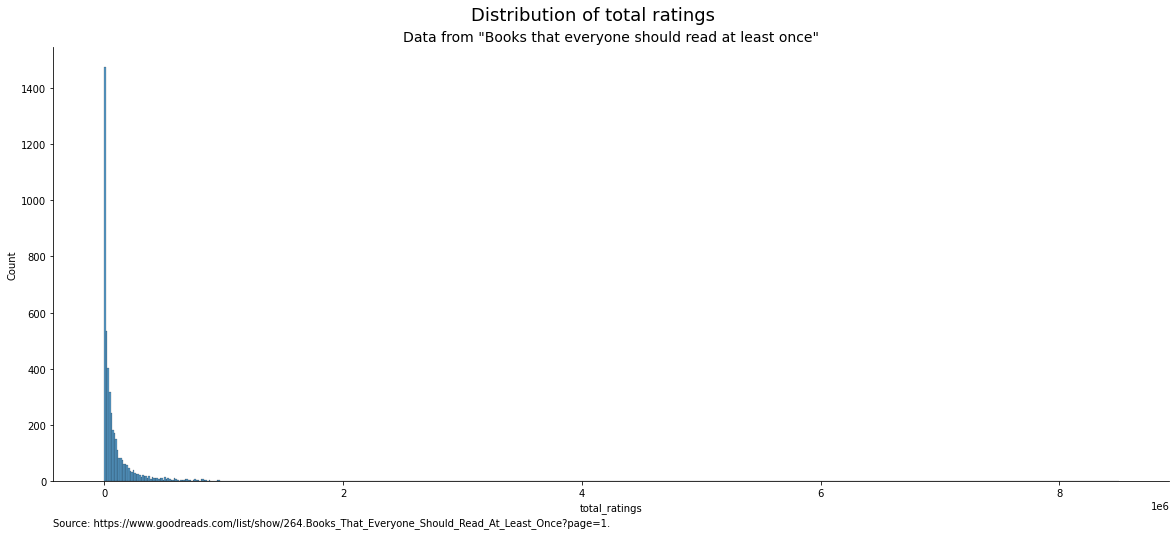

In [14]:
# create graph
plt.figure(figsize =(20,8))

sns.histplot(x = "total_ratings", data = df, palette = "mako")

# revise graph
plt.suptitle("Distribution of total ratings", fontsize = 18, y =.95)
plt.title("Data from \"Books that everyone should read at least once\"", fontsize = 14)

plt.annotate('Source: https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page=1. ', (0,-.1), xycoords ='axes fraction' )

sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [15]:
df["total_ratings"].describe()

count    4.780000e+03
mean     1.397584e+05
std      3.767257e+05
min      0.000000e+00
25%      7.448250e+03
50%      3.848750e+04
75%      1.191792e+05
max      8.496025e+06
Name: total_ratings, dtype: float64

# Looking for clusters 
Before clusters in the data can be identified, the anomalies identified in the previous section should be resolved. Therefore: 
* Avg_ratings - extreme outliers should be dropped as these may affect the clustering. 
* Total_ratings - likewise should be dropped. 
* Anonymous - open to interpretation as there are books published without an author name but they are not the norm. 

Therefore in the first instance, the avg_rating and total_ratings should be revised.

Examining the between the number of ratings and the average ratings does not appear to at face value to have clear groups. As the total number of ratings increase the avg_rating centers around 4. 

In [16]:
# find q25 and q75
q25 = df["avg_rating"].quantile(0.25)
q75 = df["avg_rating"].quantile(0.75)

# identify the range
iqr = q75-q25

# secur the upper and lower limit
upper_limit = q75 + 1.5*iqr
lower_limit = q25-1.5*iqr

# excluude variables that fall above or below the limits
df = df[(df["avg_rating"]<= upper_limit) &(df["avg_rating"]>= lower_limit)]

In [17]:
# find q25 and q75
q25 = df["total_ratings"].quantile(0.25)
q75 = df["total_ratings"].quantile(0.75)

# identify the range
iqr = q75-q25

# secur the upper and lower limit
upper_limit = q75 + 1.5*iqr
lower_limit = q25-1.5*iqr

# excluude variables that fall above or below the limits
df = df[(df["total_ratings"]<= upper_limit) &(df["total_ratings"]>= lower_limit)]

df.reset_index(drop= True, inplace = True)

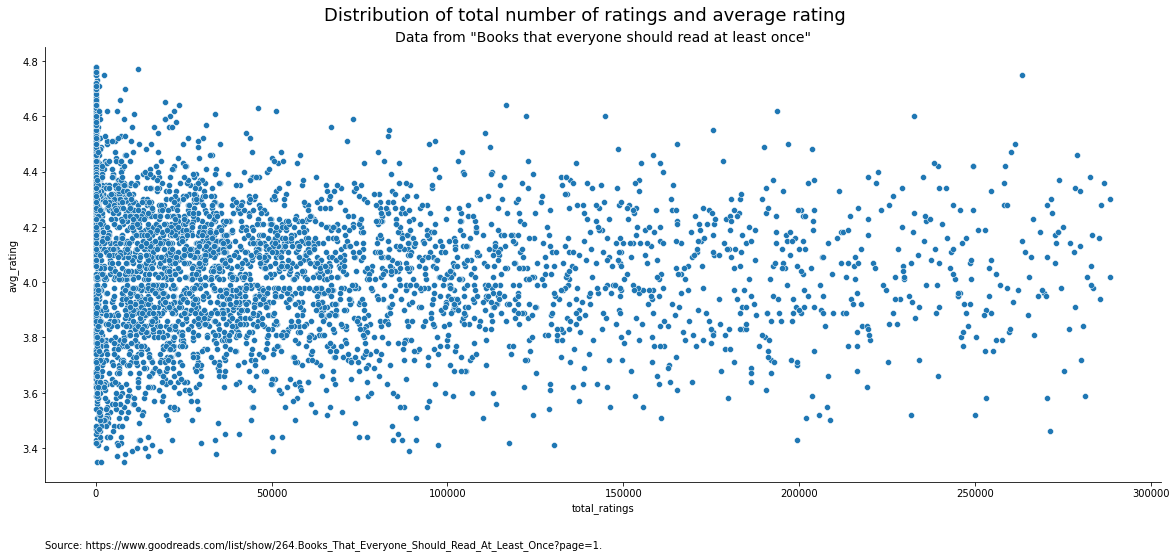

In [18]:
# plot relationship between total number and average ratings
plt.figure(figsize =(20,8))
sns.scatterplot(y ="avg_rating", x = "total_ratings", data = df, palette = "mako")

# format graph
plt.suptitle("Distribution of total number of ratings and average rating", fontsize = 18, y =.95)
plt.title("Data from \"Books that everyone should read at least once\"", fontsize = 14)

plt.annotate('Source: https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page=1. ', (0,-.15), xycoords ='axes fraction' )

sns.despine(top = True, right = True, left = False, bottom = False)

In [19]:
# plot relationship between total number and average ratings (interactive)
fig = px.scatter( df, y ="avg_rating", x = "total_ratings",
           title = "Distribution of total number of ratings and average rating <br><sup>Data from \"Books that everyone should read at least once\"</sup>", 
                )

# format graph
fig.add_annotation(
    text = ("Source: https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page=1"), showarrow=False, x = 0, y = -0.15
    , xref='paper', yref='paper', xanchor='left', yanchor='bottom', xshift=-1, yshift=-5
    , font=dict(size=10, color="grey"), align="left")

fig.update_traces(hovertemplate = 'Title=%{customdata[0]}<br>Author=%{customdata[1]}<extra></extra>')

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')

# Clustering 

A simple classification with 4 clusters appears to divide the data by the number of total reviews. 
This is not particularly enlightening. 

In [20]:
# single out numerical variables
ratings = df[["avg_rating","total_ratings"]]

#create clusters
kmeans = KMeans(4)
kmeans.fit(ratings)

# check results
clusters = kmeans.fit_predict(ratings)
clusters[:5]

# add cluster data to dataframe
data_cluster = df.copy()
data_cluster["group"] = clusters

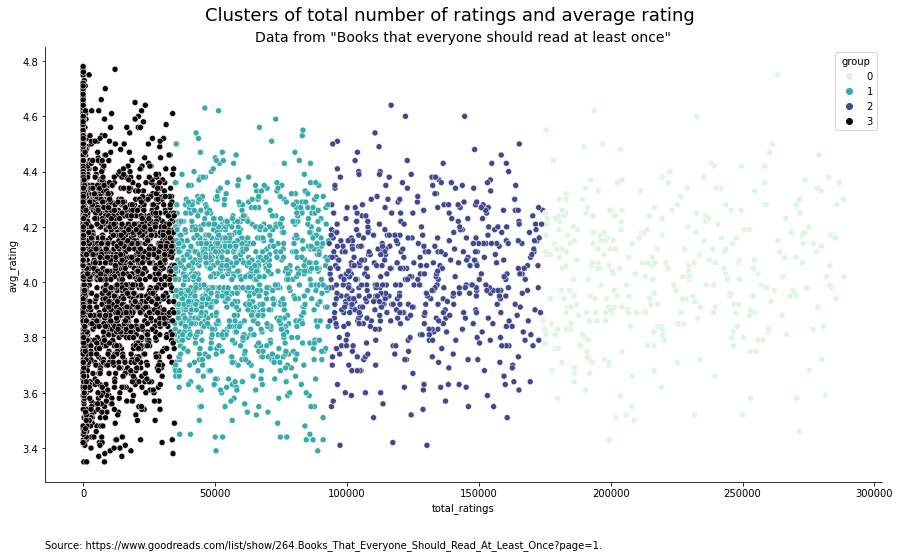

In [21]:

# create graph
plt.figure(figsize =(15,8))
sns.scatterplot(y ="avg_rating", x= "total_ratings", data = data_cluster,hue = "group", palette = "mako_r" )

# format graph
plt.suptitle("Clusters of total number of ratings and average rating", fontsize = 18, y =.95)
plt.title("Data from \"Books that everyone should read at least once\"", fontsize = 14)

plt.annotate('Source: https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page=1. ', (0,-.15), xycoords ='axes fraction' )

sns.despine(top = True, right = True, left = False, bottom = False)

In [22]:
# create graph
fig = px.scatter( data_cluster, y ="avg_rating", x = "total_ratings", color =  "group",
           title = "Clusters of total number of ratings and average rating <br><sup>Data from \"Books that everyone should read at least once\"</sup>",
                 hover_data= ["title", "author"])

# format graph
fig.add_annotation(
    text = ("Source: https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page=1"), showarrow=False, x = 0, y = -0.15
    , xref='paper', yref='paper', xanchor='left', yanchor='bottom', xshift=-1, yshift=-5
    , font=dict(size=10, color="grey"), align="left")


fig.update_traces(hovertemplate = 'Title=%{customdata[0]}<br>Author=%{customdata[1]}<extra></extra>')

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')

This may be due to the difference in scale between total_ratings and avg_ratings. 

## Modifying clustering 
To gain a better understanding of clusters, the total_ratings and avg_ratings should be standardised. This should improve the scale difference between the two variables. 

Subsequently, using the elbow method, it suggests that there are three clusters in the data.

In [23]:
from sklearn import preprocessing
ratings_scaled = preprocessing.scale(ratings)

In [24]:
# run WCSS 
wcss = []

for i in range (1, 10):
    kmeans = KMeans(i)
    kmeans.fit(ratings_scaled)
    wcss_result = kmeans.inertia_
    wcss.append(wcss_result)

Text(0.5, 0.95, 'Graph of wcss')

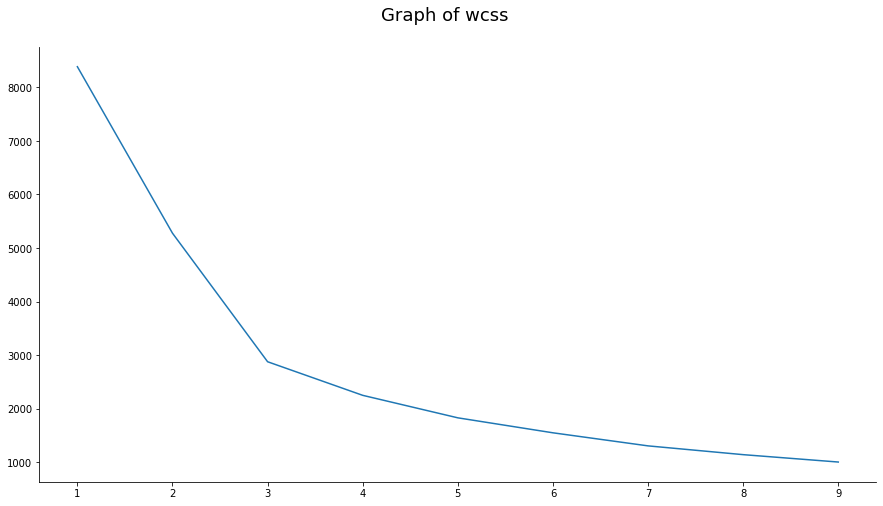

In [25]:
# plot WCSS values 

plt.figure(figsize =(15,8))
number_clusters = range (1,10)
plt.plot(number_clusters, wcss)

# format graph
sns.despine(top = True, right = True, left = False, bottom = False)
plt.suptitle("Graph of wcss", fontsize = 18, y =.95)

In [26]:
# run kmeans for 3 clusters
kmeans_new = KMeans(3)
kmeans_new.fit(ratings_scaled)
cluster_new = ratings.copy()
cluster_new["group"] = kmeans_new.predict(ratings_scaled)

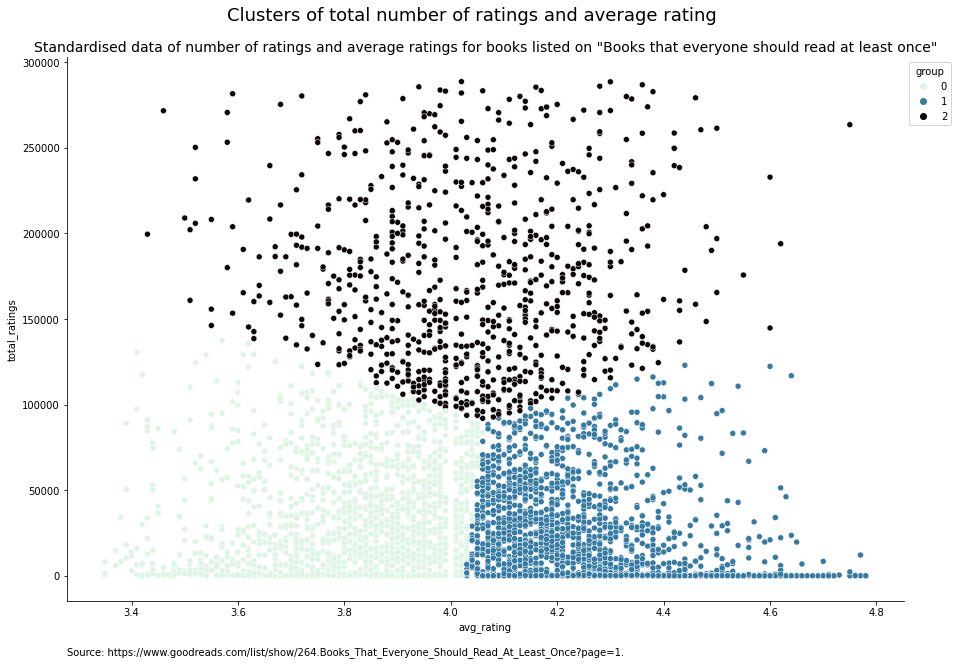

In [27]:
# plot no. of ratings and average ratings (standardised) with clusters
plt.figure(figsize =(15,10))
ax= sns.scatterplot(x ="avg_rating", y = "total_ratings", data = cluster_new,hue = "group", palette = "mako_r" )

# format graph
plt.suptitle("Clusters of total number of ratings and average rating", fontsize = 18, y =.95)
plt.title("Standardised data of number of ratings and average ratings for books listed on \"Books that everyone should read at least once\"", fontsize = 14)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.annotate('Source: https://www.goodreads.com/list/show/264.Books_That_Everyone_Should_Read_At_Least_Once?page=1. ', (0,-.1), xycoords ='axes fraction' )

sns.despine(top = True, right = True, left = False, bottom = False)

Looking at the results visually, it appears that the resulting clusters are: 
* Relatively low average rating and total rating books.
* High average rating but low to average total rating books. 
* High total rating and average average rating

For a reader, these clusters has the following implications: 

**High average rating but low to average total rating books** 
Books in this group may be ideal for those who are new to reading as the books may prove more enjoyable. 

**High total rating and average average rating** 
These may be hyped books and whilst there is a risk that the book may not be enjoyable, there may be a robust community/discussion centring around these books

**Relatively low average rating and total rating books.**
These may be more risky books as there is a higher chance of the book being a flop. As such, this may be more aimed at experienced/ avid readers. 

# Conclusion
This was a relatively short project examining Goodreads reading list, Books That Everyone Should Read At Least Once. Although the list is extensive (over 4700 books), the extensivity as well as some questionable entries (books with extremely low average and total ratings) may reduce the usability of the list for a reader. 

Although, clusters within the dataset were identified, it is not extremely robust. As such whilst the reader may find value in the clusters, they should conduct additional research before committing to a book if they are unsure. 